<h2 style='color:black' align='center'>Sports Celebrity Image Classification<h2>

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h3 style='color:black'>(1) Preprocessing: Detect face and eyes</h3>

In [2]:
img = cv2.imread('./test_images/haaland_test.jpg')
img.shape

(1707, 2560, 3)

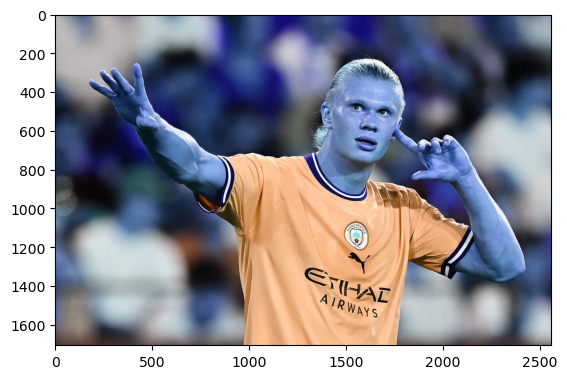

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(1707, 2560)

In [5]:
gray

array([[183, 183, 182, ..., 153, 153, 153],
       [183, 183, 182, ..., 153, 153, 153],
       [183, 183, 182, ..., 153, 153, 153],
       ...,
       [ 51,  51,  52, ..., 118, 117, 116],
       [ 51,  51,  52, ..., 117, 116, 115],
       [ 51,  51,  52, ..., 115, 114, 113]], dtype=uint8)

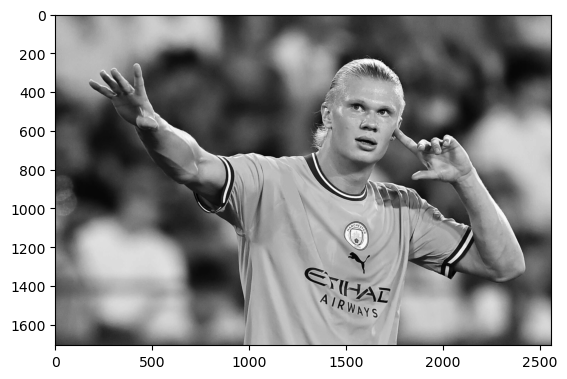

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[1420,  326,  422,  422]])

In [8]:
(x,y,w,h) = faces[0]
x,y,w,h

(1420, 326, 422, 422)

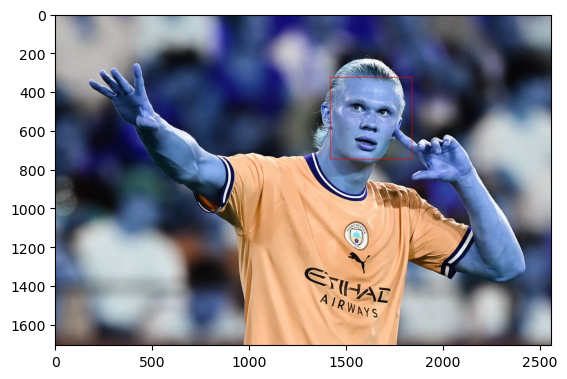

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

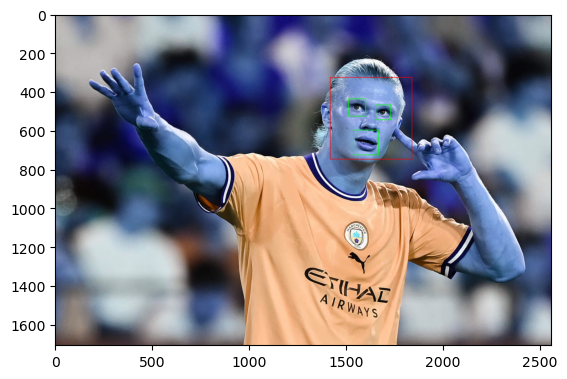

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

<h3 style='color:black'>(2) Preprocessing: Crop the facial region of the image</h3>'

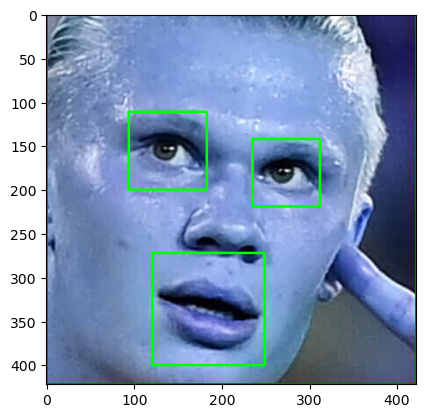

In [11]:
%matplotlib inline
plt.imshow(roi_color, cmap='gray')

In [12]:
cropped_img = np.array(roi_color)
cropped_img.shape

(422, 422, 3)

<h3 style='color:black'>(3) Preprocessing: Use wavelet transform as a feature for traning our model</h3>

### Wavelet transform

In [13]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

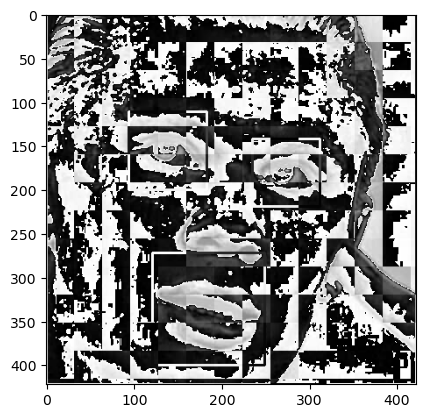

In [14]:
im_har = w2d(cropped_img,'db1',5)
plt.imshow(im_har, cmap='gray')

#### Wavelet transformed image that gives clues on facial features such as eyes, nose, lips etc. This along with raw pixel image can be used as an input for our classifier

<h3 style='color:black'>(3) Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region</h3>

####  Python function that can take input image and returns cropped image (if face and eyes >=2 are detected)

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

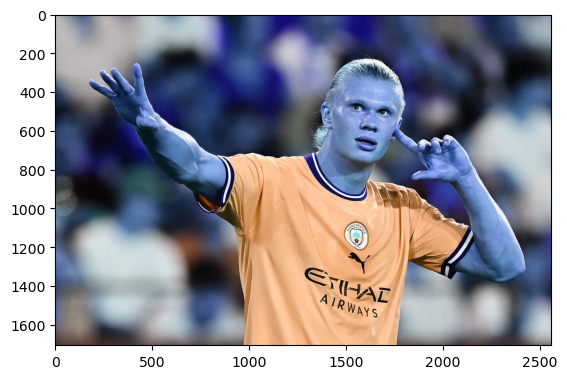

In [16]:
original_image = cv2.imread('./test_images/haaland_test.jpg')
plt.imshow(original_image)

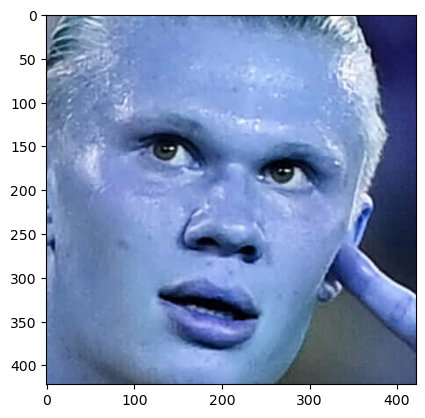

In [17]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/haaland_test.jpg')
plt.imshow(cropped_image)

**In below image face is not very clear and it doesn't have two eyes clearly visible**

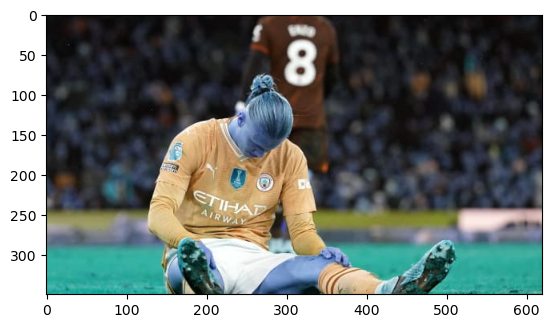

In [18]:
org_image_obstructed = cv2.imread('./test_images/haaland_test1.jpg')
plt.imshow(org_image_obstructed)

In [19]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('./test_images/haaland_test1.jpg')
cropped_image_no_2_eyes

**Above cropped_image_no_2_eyes is None which means we should ignore this image and I will not use such image for model training**

In [20]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [21]:
import os
import shutil
import cv2
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [23]:
img_dirs

['./dataset/cropped',
 './dataset/erna_solberg',
 './dataset/guri_melby',
 './dataset/jens_stoltenberg',
 './dataset/jonas_gahr',
 './dataset/sylvi_listhaug']

In [24]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print(f"[WARNING] Could not read image: {image_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_color)
        if len(eyes) >= 2:
            return roi_color
    return None

In [25]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = os.path.basename(img_dir)
    print(f"Processing celebrity: {celebrity_name}")
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        if entry.is_file() and entry.name.lower().endswith(('.jpg', '.jpeg', '.png')):
            roi_color = get_cropped_image_if_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_image_dirs.append(cropped_folder)
                    print("Generating cropped images in folder:", cropped_folder)
                
                cropped_file_name = f"{celebrity_name}{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                
                cv2.imwrite(cropped_file_path, roi_color)
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                count += 1

print("\n[INFO] Cropping complete!")

Processing celebrity: cropped
Processing celebrity: erna_solberg
Generating cropped images in folder: ./dataset/cropped/erna_solberg
Processing celebrity: guri_melby
Generating cropped images in folder: ./dataset/cropped/guri_melby
Processing celebrity: jens_stoltenberg
Generating cropped images in folder: ./dataset/cropped/jens_stoltenberg
Processing celebrity: jonas_gahr
Generating cropped images in folder: ./dataset/cropped/jonas_gahr
Processing celebrity: sylvi_listhaug
Generating cropped images in folder: ./dataset/cropped/sylvi_listhaug

[INFO] Cropping complete!


In [26]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'erna_solberg': ['./dataset/cropped/erna_solberg\\erna_solberg1.png',
  './dataset/cropped/erna_solberg\\erna_solberg10.png',
  './dataset/cropped/erna_solberg\\erna_solberg100.png',
  './dataset/cropped/erna_solberg\\erna_solberg101.png',
  './dataset/cropped/erna_solberg\\erna_solberg103.png',
  './dataset/cropped/erna_solberg\\erna_solberg104.png',
  './dataset/cropped/erna_solberg\\erna_solberg105.png',
  './dataset/cropped/erna_solberg\\erna_solberg107.png',
  './dataset/cropped/erna_solberg\\erna_solberg11.png',
  './dataset/cropped/erna_solberg\\erna_solberg110.png',
  './dataset/cropped/erna_solberg\\erna_solberg111.png',
  './dataset/cropped/erna_solberg\\erna_solberg115.png',
  './dataset/cropped/erna_solberg\\erna_solberg116.png',
  './dataset/cropped/erna_solberg\\erna_solberg118.png',
  './dataset/cropped/erna_solberg\\erna_solberg12.png',
  './dataset/cropped/erna_solberg\\erna_solberg121.png',
  './dataset/cropped/erna_solberg\\erna_solberg122.png',
  './dataset/cropped

In [27]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'erna_solberg': 0,
 'guri_melby': 1,
 'jens_stoltenberg': 2,
 'jonas_gahr': 3,
 'sylvi_listhaug': 4}

In [28]:
for celeb, files in celebrity_file_names_dict.items():
    print(celeb, len(files))

erna_solberg 112
guri_melby 102
jens_stoltenberg 128
jonas_gahr 108
sylvi_listhaug 106


In [29]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [30]:
len(X[0])

4096

In [31]:
X[0]

array([[ 62],
       [111],
       [136],
       ...,
       [ 20],
       [245],
       [243]], dtype=uint8)

In [32]:
y[0]

0

In [33]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(556, 4096)

### Training Model

Using SVM with rbf kernel tuned with heuristic finetuning



In [34]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7913669064748201

In [36]:
len(X_test)

139

In [37]:
len(X_train)

417

In [38]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.75      0.71        24
           1       0.92      0.96      0.94        25
           2       0.75      0.77      0.76        31
           3       0.73      0.75      0.74        32
           4       0.95      0.74      0.83        27

    accuracy                           0.79       139
   macro avg       0.80      0.79      0.80       139
weighted avg       0.80      0.79      0.79       139



In [39]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [40]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [41]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.846328,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.500947,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.839128,{'logisticregression__C': 10}


In [42]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=10, solver='liblinear'))])}

In [43]:
best_estimators['svm'].score(X_test,y_test)

0.8345323741007195

In [44]:
best_estimators['random_forest'].score(X_test,y_test)

0.5251798561151079

In [45]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.8273381294964028

In [46]:
best_clf = best_estimators['svm']

In [47]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[20,  2,  0,  0,  2],
       [ 1, 24,  0,  0,  0],
       [ 5,  2, 22,  1,  1],
       [ 3,  0,  0, 29,  0],
       [ 3,  1,  1,  1, 21]], dtype=int64)

Text(95.72222222222221, 0.5, 'Truth')

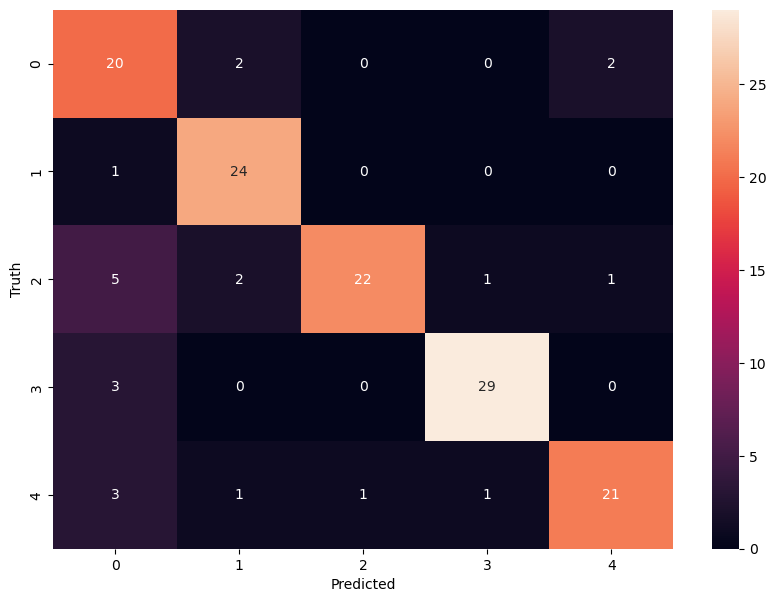

In [48]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [49]:
class_dict

{'erna_solberg': 0,
 'guri_melby': 1,
 'jens_stoltenberg': 2,
 'jonas_gahr': 3,
 'sylvi_listhaug': 4}

In [50]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl') 

['saved_model.pkl']

In [52]:
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))